In [1]:
# Fit the surface GP
import pandas as pd
from tgp.experiments import get_dataset
from tgp.gp_predictor import GPPredictor
from tgp.matern_kernels import MaternKernel32
from tgp.multiplied_kernel import MultipliedKernel
from tgp.rbf_kernel import RBFKernel
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = get_dataset()
df = df[df['start_date'].dt.year >= 2016]

In [3]:
df.head()

,ID1,ID2,ID_T,round,score,start_date,tournament_rank,surface,winner,loser,...,FAST_2,A1S_2,A2S_2,RPW_1,RPWOF_1,RPW_2,RPWOF_2,MT,round_number,year
10521,7043,25708,12783,4,6-1 6-1,2016-01-04,2,hard,Jeremy Chardy,Mubarak Shannan Zayid,...,NaN,NaN,NaN,32.0,54.0,9.0,34.0,12/30/99 00:46:22,4,2016
10522,13799,11701,12783,4,6-2 6-4,2016-01-04,2,hard,Andrey Kuznetsov,Marsel Ilhan,...,NaN,NaN,NaN,26.0,51.0,17.0,55.0,12/30/99 01:04:36,4,2016
10523,6081,18524,12783,4,5-7 6-1 7-5,2016-01-04,2,hard,Robin Haase,Aslan Karatsev,...,NaN,NaN,NaN,47.0,108.0,39.0,102.0,12/30/99 02:19:06,4,2016
10524,2379,468,12783,4,3-6 7-6(4) 7-5,2016-01-04,2,hard,Daniel Munoz-De La Nava,Feliciano Lopez,...,NaN,NaN,NaN,36.0,110.0,30.0,102.0,12/30/99 02:25:22,4,2016
10525,5992,4003,12783,4,6-2 6-2,2016-01-04,2,hard,Novak Djokovic,Dustin Brown,...,NaN,NaN,NaN,29.0,55.0,10.0,40.0,12/30/99 00:51:15,4,2016


In [4]:
mapping = {'clay': 0, 'grass': 1, 'hard': 2, 'indoor_hard': 3}

def get_surface_covariates(df):

    # Make the covariates (surface)
    covariates = df['surface']
    cov_nums = [mapping[x] for x in covariates.values]
    covariate_array = np.zeros((covariates.shape[0], len(mapping)))
    covariate_array[np.arange(covariate_array.shape[0]), cov_nums] = 1

    return covariate_array

# Prepare the input data
days_since_start = (df['start_date'] - df['start_date'].min()).dt.days.values

# We also need to one-hot encode the surface.
covariate_array = get_surface_covariates(df)

In [5]:
# Create the kernel. We need to be careful to separate the columns the kernel is going to work on.

# The time kernel works on the first column.
time_kernel = MaternKernel32(np.array([5.25]), 0.897, active_dims=[0])

# The surface kernel works on columns 1 to 4.
# It has variance 1, since we are just going to multiply it, and fixing one
# of the two multiplied kernels fixes the overall variance already.
surface_kernel = RBFKernel(np.array([2.57, 2.31, 7.47, 2.08]), 1., active_dims=[1, 2, 3, 4])

# Multiply them:
full_kernel = MultipliedKernel([time_kernel, surface_kernel])

In [6]:
# Instantiate the predictor
predictor = GPPredictor(full_kernel)

In [7]:
# Now we can fit the model:
predictor.fit(df['winner'].values, df['loser'].values, days_since_start, 
              covariates=covariate_array)

In [8]:
# OK, we've fit the model. Let's plot a player on all surfaces.
player = 'Rafael Nadal'
days_to_predict = np.linspace(days_since_start.min(), days_since_start.max(), 20)

predictions = list()

for cur_surface in mapping.keys():
    for cur_day in days_to_predict:
        # Make the one-hot encoded surface covariate
        cur_covariate = np.zeros((1, len(mapping)))
        cur_covariate[0, mapping[cur_surface]] = 1
        cur_mean, cur_sd = predictor.predict(player, cur_day, cur_covariate)
        
        predictions.append({'player': player, 'mean': cur_mean, 'sd': cur_sd, 
                            'days_since_start': cur_day, 'surface': cur_surface})
        
predictions = pd.DataFrame(predictions)

In [9]:
predictions['date'] = df['start_date'].min() + pd.to_timedelta(predictions['days_since_start'], unit='days')
predictions = predictions.set_index('surface')

Text(0.5, 1.0, "Rafael Nadal's ratings on different surfaces")

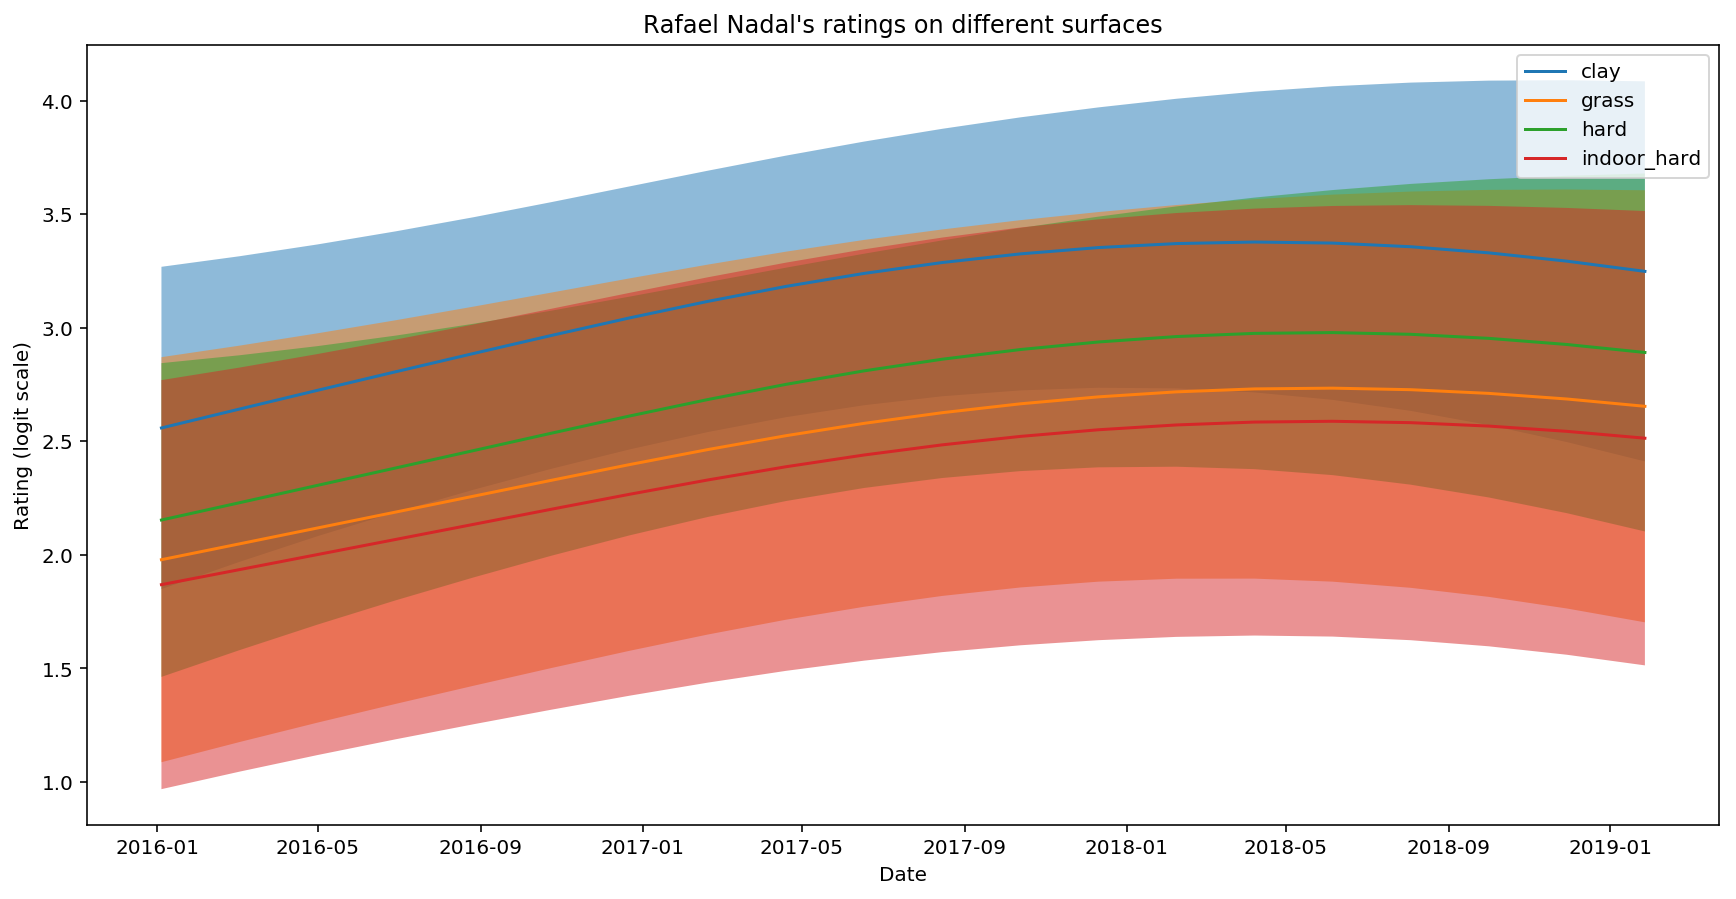

In [11]:
f, ax = plt.subplots(1, 1)

for cur_surface in mapping.keys():

    cur_data = predictions.loc[cur_surface]
    ax.plot(cur_data['date'], cur_data['mean'], label=cur_surface)
    ax.fill_between(cur_data['date'].values, cur_data['mean'] - 2 * cur_data['sd'], 
                    cur_data['mean'] + 2 * cur_data['sd'], alpha=0.5)
    
plt.legend()
f.set_size_inches(12, 6)
f.tight_layout()
ax.set_xlabel('Date')
ax.set_ylabel('Rating (logit scale)')
ax.set_title("{}'s ratings on different surfaces".format(player))

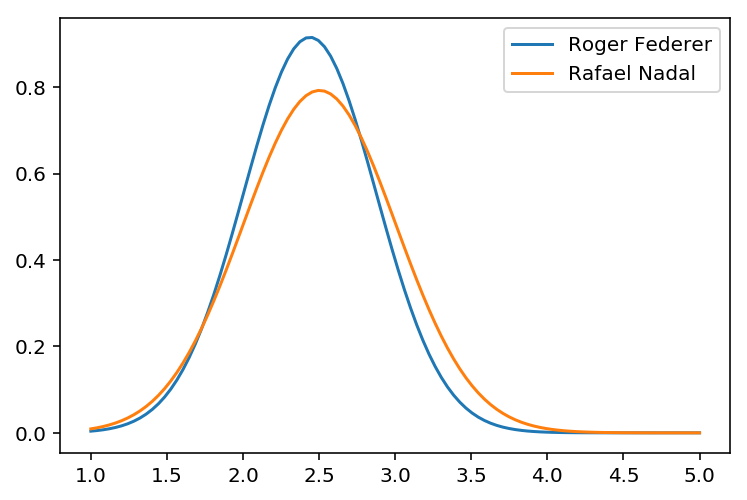

In [12]:
from datetime import datetime
from scipy.stats import norm
from scipy.special import expit

# Predict a match:
p1 = 'Roger Federer'
p2 = 'Rafael Nadal'
date = datetime(2019, 2, 15)
surface = 'indoor_hard'

surface_vector = np.zeros((1, len(mapping)))
surface_vector[0, mapping[surface]] = 1

days_since_start = (date - df['start_date'].min()).days

p1_mean, p1_sd = predictor.predict(p1, days_since_start, surface_vector)
p2_mean, p2_sd = predictor.predict(p2, days_since_start, surface_vector)

# Plot the PDF for both
x_range = np.linspace(1, 5, 100)
p1_y = norm.pdf(x_range, p1_mean, p1_sd)
p2_y = norm.pdf(x_range, p2_mean, p2_sd)

plt.plot(x_range, p1_y, label=f'{p1}')
plt.plot(x_range, p2_y, label=f'{p2}')

plt.legend()

In [13]:
# Sample from these to obtain predictions
n_draws = 100000
p1_draws = norm.rvs(p1_mean, p1_sd, size=n_draws)
p2_draws = norm.rvs(p2_mean, p2_sd, size=n_draws)
diffs = p1_draws - p2_draws

predictions = expit(diffs)
mean_pred = np.mean(predictions)

print(f'Probability that {p1} wins is estimated to be {mean_pred}.')

Probability that Roger Federer wins is estimated to be 0.48624307162808306.
